# Test Regularization on Neural Network

In [1]:
# Packages
import copy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss


%matplotlib inline

# 1. L2 regularization Model

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying your cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

## Init parameters

In [2]:
def initialize_parameters(layers_dims,n_input,n_output):
    """
    Compute the initialization of the parameters in our Neural Network

    - Arguments:
    layers_dims: array containing the dimension of the hidden layers
    n_input: numbers of features in the input layer
    n_ouput: numbers of nodes in the output layer
    type_init: "zeros","random","he" type of initialization

    - Return:
    parameters: dictionnary containing of the parameters of our neural network
    """

    # init
    parameters = {}

    # add the output layer to the array
    layers_dims.append(n_output)

    # number of layers
    L = len(layers_dims)

    for i in range(L):
        
        # if i==0 take n_x features
        if i ==0:
            layer_prev = n_input
        else:
            layer_prev = layers_dims[i-1]

        # default init
        parameters["W" + str(i+1)] = np.random.randn(layers_dims[i],layer_prev) * np.sqrt(2/layer_prev)
        parameters["b" + str(i+1)] = np.zeros((layers_dims[i],1))


    return parameters

## Forward Propagation

In [3]:
def activation_function(Z,activation_name):

    if activation_name.lower() == "sigmoid":

        A = 1/(1+np.exp(-Z))
    
    elif activation_name.lower() == "relu":

        A = np.maximum(0,Z)

    elif activation_name.lower() == "tanh":

        A = np.tanh(Z)
    
    else:
        # By default relu
        A = np.maximum(0,Z)

    return A

In [4]:
def forward_propagation(X,parameters,activation_name="relu"):

    """
    Compute the activation function
    
    Arguments:
    activation_name -- name of the activation function choosen
    Z -- items

    Returns:
    activation -- activation value
    """
    # init cache
    caches = []
    cache_layer = {}

    # layer
    L = len(parameters)//2

    # setting A_prev to X
    A_prev = X

    for i in range(1,L+1):

        # getting parameters
        W = parameters["W" + str(i)]
        b= parameters["b" + str(i)]

        # linear result
        Z = np.dot(W,A_prev) + b

        if i==L:
            # last layer -  sigmoid 
            A = activation_function(Z,"sigmoid")
        else:
            A = activation_function(Z,"relu")

        # adding to the cache
        cache = {"W" : W, "b":b,"A":A,"Z":Z,"A_prev": A_prev}

        # adding layer cache
        caches.append(cache)

        # setting A_prev
        A_prev = A

    return A, caches

## Compute Loss with or without L2 regularization

In [5]:
def cost_function(AL,y,parameters,lambd,regularization=False):

    """
    Compute the log loss L(y_pred,y)

    -- Arguments:
    y : true labels of the dataset
    AL : result of the forward propagation 

    -- Returns:
    cost : Log loss cost

    """
    L2_regularization_cost = 0

    # m examples
    m = y.shape[1]

    # 1st part of cost
    cost = (np.multiply(y,np.log(AL)) + np.multiply(1-y,np.log(1-AL)))

    # check regularization
    if regularization is False:
        cost = -(1/m) *np.nansum(cost)
    else:
        # compute L2 regularization
        for i in range(len(parameters)//2):
            W = parameters["W" + str(i+1)]
            L2_regularization_cost += np.sum(W**2)

        L2_regularization_cost = (lambd/(2*m)) * L2_regularization_cost

        # Total cost with regularization
        cost = -(1/m) *np.nansum(cost) +  L2_regularization_cost
    
    return cost

## Backward propagation With Regularization

Implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, you have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [6]:
def backward_activation(dA,Z,function_name="relu"):

    """
    Compute dZ for the backward propagation

    -- Arguments:
    dA : derivative of A
    Z : linear activation
    function_name: name of the activation_function

    -- Returns:
    dZ: derivative of Z
    """

    if function_name.lower() == "sigmoid":
        # sigmoid
        s = 1/(1+np.exp(-Z))

        # derivative sigmoid
        dG = s*(1-s)

        # dZ
        dZ = dA * dG

    elif function_name.lower() == "relu":

        # relu
        r = np.maximum(0,Z)

        # derivative relu
        dG = np.int64(r>0)

        # dZ
        dZ = np.multiply(dA,dG)

    elif function_name.lower() == "tanh":

        # tanh
        th = np.tanh(Z)

        # derivative tanh
        dG = 1-np.power(th,2)

        # dZ
        dZ = dA * dG

    else:
        # by default relu
        r = np.maximum(0,Z)

        # derivative relu
        dG = np.int64(r>0)

        # dZ
        dZ = np.multiply(dA,dG)

    return dZ

In [9]:
def backward_propagation(AL,y,caches,lambd,function_name="relu",regularization=False):

    # gradients
    gradients = {}

    # numbers of layers
    L = len(caches)

    # number of examples
    m = y.shape[1]

    # dAL
    dAL = - (np.divide(y, AL) - np.divide(1 - y, 1 - AL))
    
    # getting cache layer L
    current_cache = caches[-1]
    WL = current_cache['W']
    ZL = current_cache['Z']
    A_prev = current_cache['A_prev']

    dZL = backward_activation(dAL,ZL,"sigmoid")

    # With or without regularization
    if regularization is True:
        dW_temp = (1/m)*np.dot(dZL,A_prev.T) + (lambd/m)*WL
    else:
        dW_temp = (1/m)*np.dot(dZL,A_prev.T)

    db_temp = (1/m) * np.sum(dZL,axis=1, keepdims=True)
    dA_prev_temp = np.dot(WL.T,dZL)
    
    # compute the gradient
    gradients["dW" + str(L)] = dW_temp
    gradients["db" + str(L)] = db_temp


    for i in reversed(range(L-1)):

        # getting cache layer L
        current_cache = caches[i]
        W = current_cache['W']
        Z = current_cache['Z']
        A_prev = current_cache['A_prev']

        dZ = backward_activation(dA_prev_temp,Z,function_name)

        # with or without regularization
        if regularization is True:
            dW_temp = (1/m)*np.dot(dZ,A_prev.T) + (lambd/m)*W
        else:
             dW_temp = (1/m)*np.dot(dZ,A_prev.T)

        db_temp = (1/m) * np.sum(dZ,axis=1, keepdims=True)
        dA_prev_temp = np.dot(W.T,dZ)
        
        # compute the gradient
        gradients["dW" + str(i+1)] = dW_temp
        gradients["db" + str(i+1)] = db_temp


    return gradients


## Update parameters

In [10]:
def update_parameters(parameters,gradients,learning_rate):

    # copy 
    params = copy.deepcopy(parameters)
    
    # nb layer
    L = len(parameters)//2

    for i in range(L):
        params["W" + str(i+1)] = params["W" + str(i+1)] - learning_rate * gradients["dW" + str(i+1)]
        params["b" + str(i+1)] = params["b" + str(i+1)] - learning_rate * gradients["db" + str(i+1)]

    return params

## Predict

In [11]:
def predict(X,parameters,function_name):

    y_pred,caches = forward_propagation(X,parameters,function_name)

    y_pred = np.where(y_pred>=0.5,1,0)

    return y_pred

In [44]:
def score(X,y,parameters):
    
    # prediction
    y_pred = predict(X,parameters,function_name="relu")

    # score
    acc = accuracy_score(y.T,y_pred.T)

    return acc

## Model

In [23]:
def neural_network_model(X_train,y_train,X_test,y_test,hidden_layers_dims,n_iter,learning_rate,lambd,function_name="relu",regularization=False,display=False):

    # init trackers
    dico_model = {}
    costs_train = []
    costs_test = []
    accs_train = []
    accs_test = []

    # init
    m = X_train.shape[1]
    n_input = X_train.shape[0]
    n_output = y_train.shape[0]

    # initialize parameters
    parameters = initialize_parameters(hidden_layers_dims,n_input,n_output)


    for i in range(n_iter):

        # ---- forward propagation ------
        AL_train, caches = forward_propagation(X_train,parameters, activation_name=function_name)
        AL_test, caches_test = forward_propagation(X_test,parameters, activation_name=function_name)

        #  cost
        cost_train = cost_function(AL_train,y_train,parameters,lambd,regularization)
        costs_train.append(cost_train)

        cost_test = cost_function(AL_test,y_test,0,False)
        costs_test.append(cost_test)

        # accuracy 
        y_pred_train = predict(X_train,parameters,function_name)
        acc_train = accuracy_score(y_train.T,y_pred_train.T)
        accs_train.append(acc_train)

        y_pred_test = predict(X_test,parameters,function_name)
        acc_test = accuracy_score(y_test.T,y_pred_test.T)
        accs_test.append(acc_test)    

        # ---- bacward propagation ------
        gradients = backward_propagation(AL_train,y_train,caches,lambd,function_name,regularization)

        # ---- update params ------------
        params = update_parameters(parameters, gradients, learning_rate)
        parameters = params
        
        if display is True and i%500 == 0:
            print(f"iter {i} : Train_Loss = {cost_train}, Train_acc = {acc_train},Test_Loss = {cost_test}, Test_acc = {acc_test}")

    dict_model = {"parameters": parameters,"cost_train":costs_train,"accuracy_train":accs_train,"cost_test":costs_test,"accuracy_test":accs_test}

    return dict_model


# 2. Test on dataset

In [24]:
import scipy.io
import h5py

In [25]:
def load_2D_dataset():
    data = scipy.io.loadmat('datasets/03 - 2d Data/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

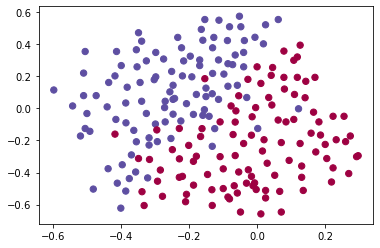

In [26]:
X_train, y_train, X_test, y_test = load_2D_dataset()

### Test 1 : Without Regularization

In [45]:
dict_model = neural_network_model(X_train,y_train,X_test,y_test,hidden_layers_dims = [20,3,1],n_iter=30000,learning_rate=0.3,lambd=0.7,function_name="relu",regularization=False,display=False)

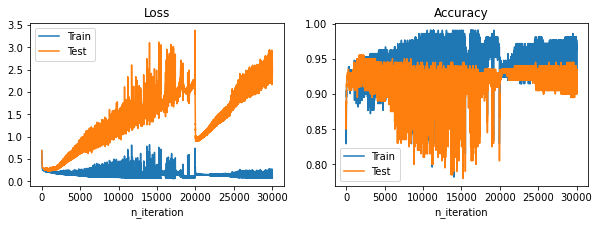

In [46]:
# Display the result

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(dict_model["cost_train"])
axs[0].plot(dict_model["cost_test"])
axs[0].set_title("Loss")
axs[0].set_xlabel("n_iteration")
axs[0].legend(["Train","Test"])

axs[1].plot(dict_model["accuracy_train"])
axs[1].plot(dict_model["accuracy_test"])
axs[1].set_title("Accuracy")
axs[1].set_xlabel("n_iteration")
axs[1].legend(["Train","Test"])
plt.show()

In [47]:
parameters = dict_model["parameters"]
acc_train = score(X_train,y_train,parameters)
acc_test = score(X_test,y_test,parameters)

print(acc_train)
print(acc_test)

0.981042654028436
0.91


### Test 2 : With Regularization

In [48]:

dict_model = neural_network_model(X_train,y_train,X_test,y_test,hidden_layers_dims = [20,3,1],n_iter=20000,learning_rate=0.3,lambd=0.7,function_name="relu",regularization=True,display=False)

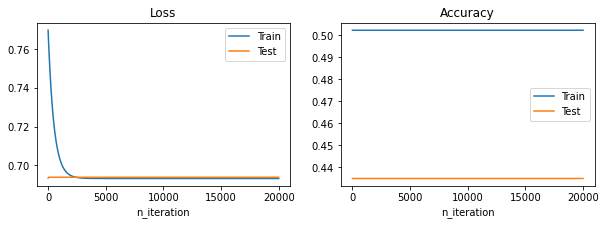

In [49]:
# Display the result

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(dict_model["cost_train"])
axs[0].plot(dict_model["cost_test"])
axs[0].set_title("Loss")
axs[0].set_xlabel("n_iteration")
axs[0].legend(["Train","Test"])

axs[1].plot(dict_model["accuracy_train"])
axs[1].plot(dict_model["accuracy_test"])
axs[1].set_title("Accuracy")
axs[1].set_xlabel("n_iteration")
axs[1].legend(["Train","Test"])
plt.show()

In [50]:
parameters = dict_model["parameters"]
acc_train = score(X_train,y_train,parameters)
acc_test = score(X_test,y_test,parameters)

print(acc_train)
print(acc_test)

0.5023696682464455
0.435
